# [E-09] 프로젝트: 네이버 영화리뷰 감성분석 도전하기

<br>

---

## 1) 데이터 준비와 확인

In [123]:
import pandas as pd
import tensorflow as tf
import konlpy
import gensim

# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

In [3]:
train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [4]:
test_data.head()

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


In [5]:
print('train_data의 shape :', train_data.shape)
print('test_data의 shape :', test_data.shape)

train_data의 shape : (150000, 3)
test_data의 shape : (50000, 3)


## 2) 데이터로더 구성

- Naver Sentimental Movie Corpus 데이터는 가공되지 않은 텍스트 파일로 전처리가 필요하다.


- 따라서 `imdb.data_loader()`와 동일하게 동작하는 data_loader를 만들어보자.


- 데이터 중복 제거
- NaN 결측치 제거
- 한국어 토크나이저로 토큰화
- 불용어(stopwords) 제거
- 사전 word_to_index 구성
- 텍스트 스트링을 사전 인덱스 스트링으로 변환

**즉, `X_train`, `y_train`, `X_test`, `y_test`, `word_to_index` 리턴**

In [12]:
train_data['document'].value_counts()

굿                                                                                                  181
good                                                                                                92
최고                                                                                                  85
쓰레기                                                                                                 79
별로                                                                                                  66
                                                                                                  ... 
이런거 만드는 색휘는 진짜 일부로 욕처묵고싶어서 환장한색휘인듯                                                                   1
이영화 평점이 궁금해서 왔는데.너무높다..^^                                                                            1
시청자들에게 사과하세여 제작진..낚시성 예고 지친다..보기싫음 말아라 하고 만듬?조세호씨 때문에 넘웃기게 보는데요 낚시그만하시고 예고와 본방이 이어지는 연출부탁드립니다..      1
여태본 영화중 단연 최고                                                            

In [15]:
train_data[train_data['document'] == '별로']

,id,document,label
4502,6088734,별로,0
5897,4837452,별로,0
7150,7379084,별로,0
11433,5612565,별로,0
14295,5585809,별로,0
...,...,...,...
141478,858201,별로,0
142562,7666208,별로,0
142618,6309396,별로,0
145210,6819730,별로,0


In [16]:
from konlpy.tag import Mecab
import numpy as np
from collections import Counter

In [61]:
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
#     vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    vocab = ['', '', '', ''] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index[''] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data) 

In [63]:
# 처음 몇 개 인덱스는 사전에 정의되어 있습니다
word_to_index["<PAD>"] = 0
word_to_index["<BOS>"] = 1
word_to_index["<UNK>"] = 2  # unknown

In [64]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [68]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

## 3) 모델 구성을 위한 데이터 분석 및 가공

#### - 데이터셋 내 문장 길이 분포<br><br>- 적절한 최대 문장 길이 지정<br><br>- `keras.preprocessing.sequence.pad_sequences`을 활용한 패딩 추가

**`pad_sequences`**를 통해 데이터셋 상의 문장의 길이를 통일해야 함.


- 문장 최대 길이 maxlen의 값 설정도 젠체 모델 성능에 영향을 미침.

In [71]:
total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성환 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값 / 최대값 / 표준편차를 계산해본다.
print('문장길이 평균 :', np.mean(num_tokens))
print('문장길이 최대 :', np.max(num_tokens))
print('문장길이 표준편차 :', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,
max_tokens = np.mean(num_tokens) + 2*np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균 : 15.96940191154864
문장길이 최대 : 116
문장길이 표준편차 : 12.843571191092
pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


In [76]:
X_train_padding = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='post', # 혹은 'pre'
                                                        maxlen=maxlen)

X_test_padding = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='post', # 혹은 'pre'
                                                       maxlen=maxlen)

print(X_train_padding.shape)
print(X_test_padding.shape)

(146182, 41)
(49157, 41)


## 4) 모델 구성 및 Validation Set 구성

- model 훈련 전에, 훈련용 데이터셋 25000건 중 10000 건을 분리하여 검증셋으로 사용한다.<br><br>
- 모델은 3가지 이상 다양하게 구성하여 실험해보자

In [97]:
# # validation set 10000건 분리
# X_val = X_train_padding[:10000]   
# y_val = y_train[:10000]

# # validation set을 제외한 나머지 15000건
# partial_x_train = X_train_padding[10000:]  
# partial_y_train = y_train[10000:]

# print(partial_x_train.shape)
# print(partial_y_train.shape)
# print(X_val.shape)
# print(y_val.shape)

In [100]:
from sklearn.model_selection import train_test_split

partial_x_train, X_val, partial_y_train, y_val = train_test_split(X_train_padding, y_train, test_size=0.2, random_state=1234)

In [101]:
print(partial_x_train.shape)
print(partial_y_train.shape)
print(X_val.shape)
print(y_val.shape)

(116945, 41)
(116945,)
(29237, 41)
(29237,)


In [77]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 16  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

### 1) 1D Convolution
model1 = tf.keras.Sequential()
model1.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model1.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model1.add(tf.keras.layers.MaxPooling1D(5))
model1.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model1.add(tf.keras.layers.GlobalMaxPooling1D())
model1.add(tf.keras.layers.Dense(8, activation='relu'))
model1.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

### 2) LSTM
model2 = tf.keras.Sequential()
model2.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model2.add(tf.keras.layers.LSTM(8))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
model2.add(tf.keras.layers.Dense(8, activation='relu'))
model2.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

### 3) GlobalMaxPooling
model3 = tf.keras.Sequential()
model3.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model3.add(tf.keras.layers.GlobalMaxPooling1D())
model3.add(tf.keras.layers.Dense(8, activation='relu'))
model3.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

In [78]:
model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160000    
_________________________________________________________________
conv1d (Conv1D)              (None, None, 16)          1808      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 16)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 8)                 136       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9

In [79]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
lstm (LSTM)                  (None, 8)                 800       
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9         
Total params: 160,881
Trainable params: 160,881
Non-trainable params: 0
_________________________________________________________________


In [80]:
model3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 16)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 160,145
Trainable params: 160,145
Non-trainable params: 0
_________________________________________________________________


## 5) 모델 훈련 및 평가

- model1 : 1D Convolution Network
- model2 : LSTM
- model3 : GlobalMaxPooling

In [102]:
model1.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model2.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model3.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=50  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

In [103]:
# 1D Convolution

history1 = model1.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/50
229/229 [==============================] - 5s 6ms/step - loss: 0.4866 - accuracy: 0.7573 - val_loss: 0.3616 - val_accuracy: 0.8430
Epoch 2/50
229/229 [==============================] - 1s 5ms/step - loss: 0.3309 - accuracy: 0.8586 - val_loss: 0.3469 - val_accuracy: 0.8514
Epoch 3/50
229/229 [==============================] - 1s 5ms/step - loss: 0.2991 - accuracy: 0.8747 - val_loss: 0.3494 - val_accuracy: 0.8480
Epoch 4/50
229/229 [==============================] - 1s 5ms/step - loss: 0.2727 - accuracy: 0.8888 - val_loss: 0.3521 - val_accuracy: 0.8496
Epoch 5/50
229/229 [==============================] - 1s 5ms/step - loss: 0.2431 - accuracy: 0.9031 - val_loss: 0.3624 - val_accuracy: 0.8462
Epoch 6/50
229/229 [==============================] - 1s 5ms/step - loss: 0.2087 - accuracy: 0.9210 - val_loss: 0.3867 - val_accuracy: 0.8432
Epoch 7/50
229/229 [==============================] - 1s 5ms/step - loss: 0.1742 - accuracy: 0.9363 - val_loss: 0.4235 - val_accuracy: 0.8389
Epoch 

In [104]:
# LSTM

history2 = model2.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/50
229/229 [==============================] - 3s 7ms/step - loss: 0.5725 - accuracy: 0.6719 - val_loss: 0.3924 - val_accuracy: 0.8327
Epoch 2/50
229/229 [==============================] - 1s 6ms/step - loss: 0.3507 - accuracy: 0.8522 - val_loss: 0.3520 - val_accuracy: 0.8481
Epoch 3/50
229/229 [==============================] - 1s 5ms/step - loss: 0.3182 - accuracy: 0.8657 - val_loss: 0.3540 - val_accuracy: 0.8476
Epoch 4/50
229/229 [==============================] - 1s 5ms/step - loss: 0.3034 - accuracy: 0.8713 - val_loss: 0.3514 - val_accuracy: 0.8493
Epoch 5/50
229/229 [==============================] - 1s 5ms/step - loss: 0.2917 - accuracy: 0.8764 - val_loss: 0.3545 - val_accuracy: 0.8466
Epoch 6/50
229/229 [==============================] - 1s 5ms/step - loss: 0.2811 - accuracy: 0.8787 - val_loss: 0.3653 - val_accuracy: 0.8475
Epoch 7/50
229/229 [==============================] - 1s 5ms/step - loss: 0.2706 - accuracy: 0.8824 - val_loss: 0.3774 - val_accuracy: 0.8443
Epoch 

In [105]:
# GlobalMaxPooling

history3 = model3.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/50
229/229 [==============================] - 1s 4ms/step - loss: 0.6135 - accuracy: 0.7504 - val_loss: 0.4629 - val_accuracy: 0.8158
Epoch 2/50
229/229 [==============================] - 1s 3ms/step - loss: 0.3896 - accuracy: 0.8353 - val_loss: 0.3692 - val_accuracy: 0.8366
Epoch 3/50
229/229 [==============================] - 1s 3ms/step - loss: 0.3317 - accuracy: 0.8593 - val_loss: 0.3564 - val_accuracy: 0.8423
Epoch 4/50
229/229 [==============================] - 1s 3ms/step - loss: 0.3033 - accuracy: 0.8732 - val_loss: 0.3550 - val_accuracy: 0.8434
Epoch 5/50
229/229 [==============================] - 1s 3ms/step - loss: 0.2829 - accuracy: 0.8830 - val_loss: 0.3585 - val_accuracy: 0.8445
Epoch 6/50
229/229 [==============================] - 1s 3ms/step - loss: 0.2667 - accuracy: 0.8911 - val_loss: 0.3644 - val_accuracy: 0.8450
Epoch 7/50
229/229 [==============================] - 1s 3ms/step - loss: 0.2531 - accuracy: 0.8974 - val_loss: 0.3718 - val_accuracy: 0.8434
Epoch 

## 6) Loss, Accuracy 그래프 시각화

In [115]:
import matplotlib.pyplot as plt

history_dict1 = history1.history
history_dict2 = history2.history
history_dict3 = history3.history

print(history_dict3.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


#### (1) 1D Convolution 시각화

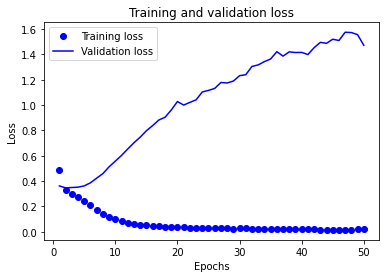

In [116]:
acc = history_dict1['accuracy']
val_acc = history_dict1['val_accuracy']
loss = history_dict1['loss']
val_loss = history_dict1['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

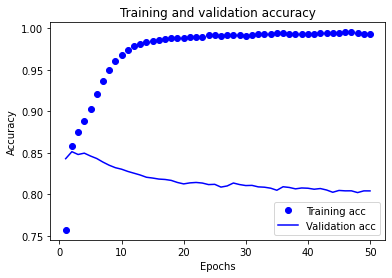

In [117]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

#### (2) LSTM 시각화

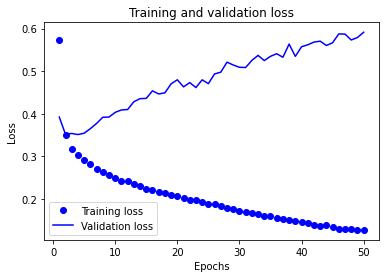

In [118]:
acc = history_dict2['accuracy']
val_acc = history_dict2['val_accuracy']
loss = history_dict2['loss']
val_loss = history_dict2['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

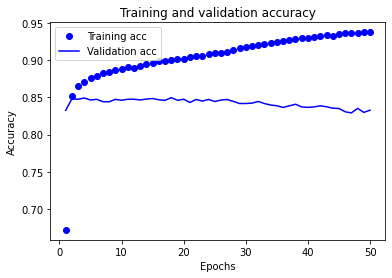

In [119]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

#### (3) GlobalMaxPooling 시각화

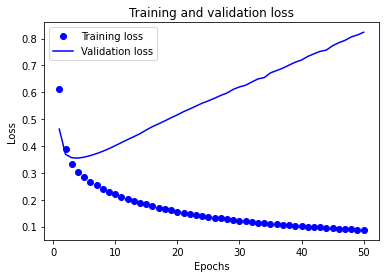

In [120]:
acc = history_dict3['accuracy']
val_acc = history_dict3['val_accuracy']
loss = history_dict3['loss']
val_loss = history_dict3['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

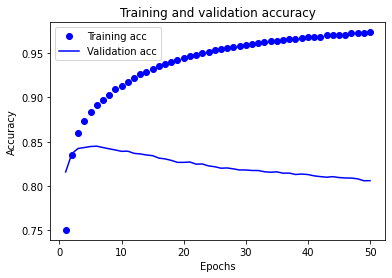

In [121]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

**Training & Validation Loss 및 Accuracy를 그려봤더니, 3개의 모델 모두 epoch 초반부터 train과 validation의 이격이 발생하게 되었다.**<br><br>**더이상 트래이닝은 무의미해지게 되었다.**<br><br>

## 7) 모델 평가

In [106]:
results1 = model1.evaluate(X_test_padding,  y_test, verbose=2)
results2 = model2.evaluate(X_test_padding,  y_test, verbose=2)
results3 = model3.evaluate(X_test_padding,  y_test, verbose=2)

1537/1537 - 2s - loss: 1.4889 - accuracy: 0.8039
1537/1537 - 3s - loss: 0.6073 - accuracy: 0.8303
1537/1537 - 2s - loss: 0.8278 - accuracy: 0.8070
[1.4889326095581055, 0.8038733005523682]


In [113]:
print('loss   /   accuracy\n')

print('1D convolution network :')
print(results1)
print('\nLSTM :')
print(results2)
print('\nGlobalMaxPooling :')
print(results3)

loss   /   accuracy

1D convolution network :
[1.4889326095581055, 0.8038733005523682]

LSTM :
[0.607270359992981, 0.8302988409996033]

GlobalMaxPooling :
[0.8277708888053894, 0.8069857954978943]


**3개의 모델 모두 정확도 80% 이상 달성하였으나, 만족할만한 수준이 아니다.**<br><br>

In [170]:
embedding_layer1 = model1.layers[0]
weights1 = embedding_layer1.get_weights()[0]
print(weights1.shape)    # shape: (vocab_size, embedding_dim)


(10000, 16)


In [171]:
embedding_layer2 = model2.layers[0]
weights2 = embedding_layer2.get_weights()[0]
print(weights2.shape)    # shape: (vocab_size, embedding_dim)


(10000, 16)


In [172]:
embedding_layer3 = model3.layers[0]
weights3 = embedding_layer3.get_weights()[0]
print(weights3.shape)    # shape: (vocab_size, embedding_dim)


(10000, 16)


In [173]:
pwd

'/aiffel/aiffel/_LMS_Exploration/Ex09'

**1) 1D Convolution Model**

In [176]:
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = os.getenv('HOME')+'/aiffel/_LMS_Exploration/Ex09/word2vec1.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model1.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [180]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['love']
vector

array([-0.08319904,  0.26484504, -0.08875954,  0.1924765 , -0.09777966,
       -0.09028587, -0.08082014,  0.32777658, -0.01417674, -0.0572833 ,
       -0.00742436, -0.02296383, -0.07255041,  0.09934525,  0.3082196 ,
       -0.08502151], dtype=float32)

In [181]:
word_vectors.similar_by_word("love")

[('밋기', 0.9540770053863525),
 ('뿅', 0.9494259357452393),
 ('신들린', 0.9380380511283875),
 ('어울려요', 0.9294651746749878),
 ('♥♥♥♥', 0.9280003309249878),
 ('임다', 0.9247182607650757),
 ('테일러', 0.92218416929245),
 ('겠어요', 0.920279860496521),
 ('박선영', 0.9202494621276855),
 ('♥♥', 0.9042508006095886)]

**2) LSTM Model**

In [182]:
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = os.getenv('HOME')+'/aiffel/_LMS_Exploration/Ex09/word2vec2.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model2.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [183]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['love']
vector

array([ 0.29398888,  0.14956327, -0.34447357, -0.19779214, -0.52882856,
        0.40712944,  0.22959511,  0.31017867,  0.26558945,  0.23440947,
       -0.41575924, -0.04797458,  0.20186499,  0.25046378, -0.23095496,
       -0.13149054], dtype=float32)

In [184]:
word_vectors.similar_by_word("love")

[('담겨져', 0.990083634853363),
 ('빛났', 0.9899144172668457),
 ('캡', 0.9898021221160889),
 ('숨죽이', 0.9879760146141052),
 ('서동요', 0.9872287511825562),
 ('탕웨이', 0.9865471124649048),
 ('놀라웠', 0.9845993518829346),
 ('며느리', 0.9841988682746887),
 ('킹왕짱', 0.9822003245353699),
 ('역경', 0.9818530082702637)]

**3) GlobalMaxPooling Model**

In [185]:
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = os.getenv('HOME')+'/aiffel/_LMS_Exploration/Ex09/word2vec3.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model3.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [186]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['love']
vector

array([-0.08319904,  0.26484504, -0.08875954,  0.1924765 , -0.09777966,
       -0.09028587, -0.08082014,  0.32777658, -0.01417674, -0.0572833 ,
       -0.00742436, -0.02296383, -0.07255041,  0.09934525,  0.3082196 ,
       -0.08502151], dtype=float32)

In [187]:
word_vectors.similar_by_word("love")

[('밋기', 0.9540770053863525),
 ('뿅', 0.9494259357452393),
 ('신들린', 0.9380380511283875),
 ('어울려요', 0.9294651746749878),
 ('♥♥♥♥', 0.9280003309249878),
 ('임다', 0.9247182607650757),
 ('테일러', 0.92218416929245),
 ('겠어요', 0.920279860496521),
 ('박선영', 0.9202494621276855),
 ('♥♥', 0.9042508006095886)]

## 8) 한국어 Word2Vec 임베딩 활용하여 성능 개선

**`gensim` 버전 3.x.x 대로 낮추기**

In [159]:
!pip install --upgrade gensim==3.6.0

     |████████████████████████████████| 23.1 MB 5.6 MB/s            
  Preparing metadata (setup.py) ... done
  Created wheel for gensim: filename=gensim-3.6.0-cp39-cp39-linux_x86_64.whl size=23393062 sha256=29886ede3ab9be21b5d0dd2a8c73d14a2a6638b86d2766f30a97d798a546f092
  Stored in directory: /aiffel/.cache/pip/wheels/61/12/f2/84de20fba5e870553796b0834d11109992f06ddc20aaead086
Successfully built gensim
  Attempting uninstall: gensim
    Found existing installation: gensim 3.8.3
    Uninstalling gensim-3.8.3:
      Successfully uninstalled gensim-3.8.3


In [160]:
print(gensim.__version__)

4.1.2


In [165]:
# # import os.getenv('HOME') + '/sentiment_classification/data/build_corpus.py'
# import word2vec_ko_path

In [166]:
import os
from gensim.models import KeyedVectors


word2vec_ko_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/ko.bin'

In [167]:
word2vec_ko_path

'/aiffel/aiffel/sentiment_classification/data/ko.bin'

In [169]:
word2vec_ko = KeyedVectors.load_word2vec_format(word2vec_ko_path, binary=True, limit=1000000)


UnicodeDecodeError: 'utf-8' codec can't decode byte 0x80 in position 0: invalid start byte

## 9) 결론 및 회고

- 네이버 영화리뷰 감성분석 프로젝트를 진행해보았다. <br> `Naver Sentimental Movie Corpus`에서 Dataset을 다운받아 pandas DataFrame으로 데이터를 가져올 수 있었다. 해당 데이터셋은 가공되지 않은 텍스트 파일이여서 전처리를 해주어야 했다. <br>결측치 처리가 완료된 후 임베딩 레이어에 입력으로 데이터를 넣기 위해 최대 문장길이를 지정하고 padding을 수행했다.<br> Train Dataset은 Train_test_split 함수를 사용해서 Validation set을 0.2 비중을 갖도록 나눴다.<br> 모델은 3가지 모델로 구성하였다. 1) 1D Convolution Network Model 2) LSTM Model 3) GlobalMaxPooling Model을 사용하였다. 각각 모델을 학습시키고 Loss / Accuracy 그래프 시각화를 통해 학습된 모델의 성능을 검증하였다. <br> 또한, `GenSim`을 활용하여 자체 학습된 임베딩 레이어를 분석을 진행하였는데, LSTM을 제외한 1D Convolution Model / GlobalMaxPooling Model이 유사한 단어들을 출력하는것을 확인했다. 


- 한국어 Word2Vec을 활용하기 위해 gensim 모델의 버전을 3.x.x대로 변경하려 하였으나 본 컨테이너에서는 버전 변경 후에도 계속해서 4.x.x대 버전을 유지하고 있어서 계속해서 에러가 나는 것 같았다.. 이를 해결하기 위해 구글 코랩으로 진행해보려 했으나, Mecab()에러를 해결하기 못하였다. 추후에 해당 문제를 해결하고 적용해보도록 할 예정이다.